In [13]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
from matplotlib.colors import ListedColormap

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout


In [2]:
poa = gpd.read_file("poa_selected.gpkg")
sa1 = gpd.read_file("sa1_to_poa.gpkg")
sa1 = sa1[["SA1_CODE21", "POA_CODE21", "geometry"]]
poa = poa[["POA_CODE21", "geometry"]]

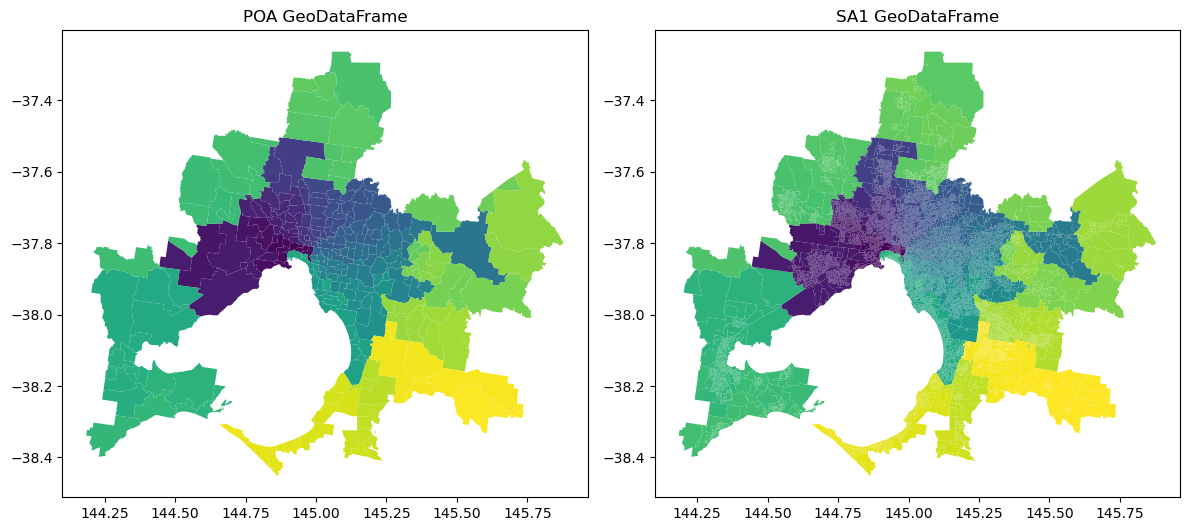

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 
poa.plot(column="POA_CODE21", cmap='viridis', ax=axes[0])
axes[0].set_title("POA GeoDataFrame")
sa1.plot(column="POA_CODE21", cmap='viridis', ax=axes[1])
axes[1].set_title("SA1 GeoDataFrame")
plt.tight_layout() 
plt.show()

In [7]:
# Import synthetic populaiton
synthetic = pd.read_csv("clean_data.csv")
synthetic["SA1"] = synthetic["SA1"].astype(str)
synthetic_merged = sa1.merge(synthetic, left_on="SA1_CODE21", right_on="SA1", how="right")

6386.0


,POA_CODE21,TOTAL1
0,3000,62.0
1,3002,29.0
2,3003,25.0
3,3004,26.0
4,3006,33.0
...,...,...
301,3230,13.0
302,3240,8.0
303,3331,11.0
304,3340,28.0


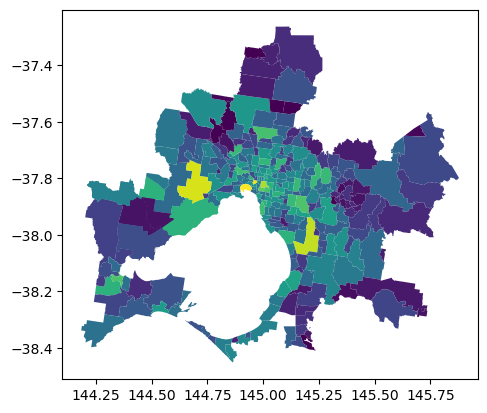

In [67]:
# Import Rego Data 
rego = pd.read_csv("Whole_Fleet_Vehicle_Registration_Snapshot_by_Postcode_Q2_2023.csv")
evs = rego[rego["CD_CL_FUEL_ENG"]=="E "] # Get only Eletric 
evs = evs[(evs["POSTCODE"] >= 3000) & (evs["POSTCODE"] < 4000) ] # Get Vic Postcodes 
evs = evs[evs["NB_YEAR_MFC_VEH"].astype(int) > 2018] # Remove E older than 2018 (last 5 years)
evs = evs[evs["TOTAL1"] <= 2]
evs = evs.reset_index(drop=True)
evs = evs[["POSTCODE", "TOTAL1"]]
evs = evs.groupby("POSTCODE").sum().reset_index()
evs["POSTCODE"] = evs["POSTCODE"].astype(str)
total_evs = evs["TOTAL1"].sum()
evs_merged = poa.merge(evs, left_on="POA_CODE21", right_on="POSTCODE", how="left").drop(columns="POSTCODE")
evs_merged["TOTAL1"].fillna(0, inplace=True)
ev_totals = evs_merged[["POA_CODE21","TOTAL1"]]
pred_poa = poa.merge(ev_totals, left_on="POA_CODE21", right_on="POA_CODE21", how="left", )
pred_poa.plot(column="TOTAL1", cmap='viridis')
print(ev_totals["TOTAL1"].sum())
display(ev_totals)

In [47]:
total_evs = synthetic_merged.merge(ev_totals, left_on="POA_CODE21", right_on="POA_CODE21", how="inner").drop_duplicates(subset=["POA_CODE21"])
total_evs = total_evs[["POA_CODE21", "SA1_CODE21", "TOTAL1"]]

In [48]:
categorical_columns = ["dwelltype_Flat or Apartment", "dwelltype_Separate House", "dwelltype_Terrace/Townhouse",
                       "owndwell_Being Purchased", "owndwell_Being Rented", "owndwell_Fully Owned", "owndwell_Occupied Rent-Free"]

hist_values = []
num_bins = 10 
labels = []

postcodes = total_evs.merge(synthetic_merged, left_on="POA_CODE21", right_on="POA_CODE21", how="right").dropna()["POA_CODE21"].unique()

for postcode in postcodes:
    hist_values_postcode = []
    selected = synthetic_merged[synthetic_merged["POA_CODE21"] == postcode]

    for attribute in ["INC", "TOTALVEHS", "HHSIZE"]:
        hist, _ = np.histogram(selected[attribute], bins=num_bins)
        hist_values_postcode.extend(hist)
    
    categorical_sums = selected[categorical_columns].sum().values
    hist_values_postcode.extend(categorical_sums)

    hist_values.append(hist_values_postcode)
    labels.append(ev_totals[ev_totals["POA_CODE21"] == postcode]["TOTAL1"].values[0])

data = np.array(hist_values)
labels = np.array(labels)

In [49]:
print(data.shape)
print(postcodes.shape)
print(labels.shape)

(281, 37)
(281,)
(281,)


Epoch 1/20
1/1 [==============================] - 1s 667ms/step - loss: 903.4058 - mean_absolute_error: 903.4058 - val_loss: 2584.5366 - val_mean_absolute_error: 2584.5366
Epoch 2/20
1/1 [==============================] - 0s 32ms/step - loss: 1835.1912 - mean_absolute_error: 1835.1912 - val_loss: 1388.4048 - val_mean_absolute_error: 1388.4048
Epoch 3/20
1/1 [==============================] - 0s 29ms/step - loss: 1159.2523 - mean_absolute_error: 1159.2523 - val_loss: 424.0467 - val_mean_absolute_error: 424.0467
Epoch 4/20
1/1 [==============================] - 0s 28ms/step - loss: 426.0721 - mean_absolute_error: 426.0721 - val_loss: 356.5974 - val_mean_absolute_error: 356.5974
Epoch 5/20
1/1 [==============================] - 0s 27ms/step - loss: 353.8950 - mean_absolute_error: 353.8950 - val_loss: 419.9770 - val_mean_absolute_error: 419.9770
Epoch 6/20
1/1 [==============================] - 0s 28ms/step - loss: 391.0146 - mean_absolute_error: 391.0146 - val_loss: 300.0667 - val_mean_ab

c:\Users\danla\anaconda3\envs\fYP\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


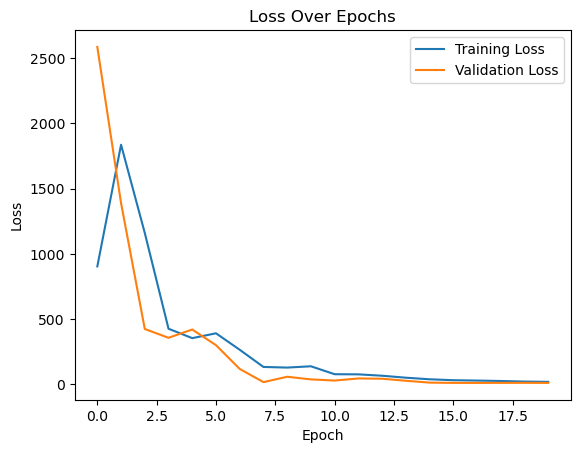

2/2 [==============================] - 0s 4ms/step - loss: 8.9449 - mean_absolute_error: 8.9449
Test loss: [8.944866180419922, 8.944866180419922]
9/9 [==============================] - 0s 939us/step


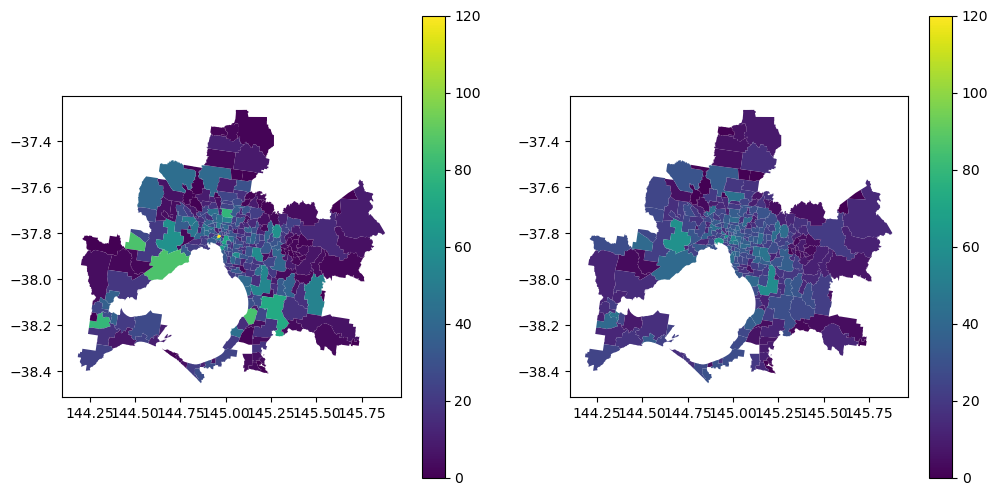

In [56]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Create a CNN model
cnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(37,)),
    Dropout(0.3),  # Add dropout layer with dropout rate of 0.3
    Dense(64, activation='relu'),
    Dropout(0.3),  # Add dropout layer with dropout rate of 0.3
    Dense(1)
])

# Compile the model with the specified optimizer and loss function
optimizer = Adam(learning_rate=0.01)
cnn_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])

# Reshape your data to add a channel dimension
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Train the model
history = cnn_model.fit(X_train_cnn, y_train, epochs=20, batch_size=X_train.shape[0], validation_split=0.4)

# Save the trained model
# cnn_model.save("my_model2.h5")

# Visualize the loss history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss = cnn_model.evaluate(X_test_cnn, y_test)
print("Test loss:", loss)

predicted = cnn_model.predict(data)
predicted[predicted < 0] = 0
rounded_predicted = np.round(predicted).astype(int)
total_evs["pred"] = rounded_predicted
pred_poa = poa.merge(total_evs, left_on="POA_CODE21", right_on="POA_CODE21", how="outer")
pred_poa.loc[pd.isna(pred_poa["TOTAL1"]), "TOTAL1"] = 0
pred_poa.loc[pd.isna(pred_poa["pred"]), "pred"] = 0


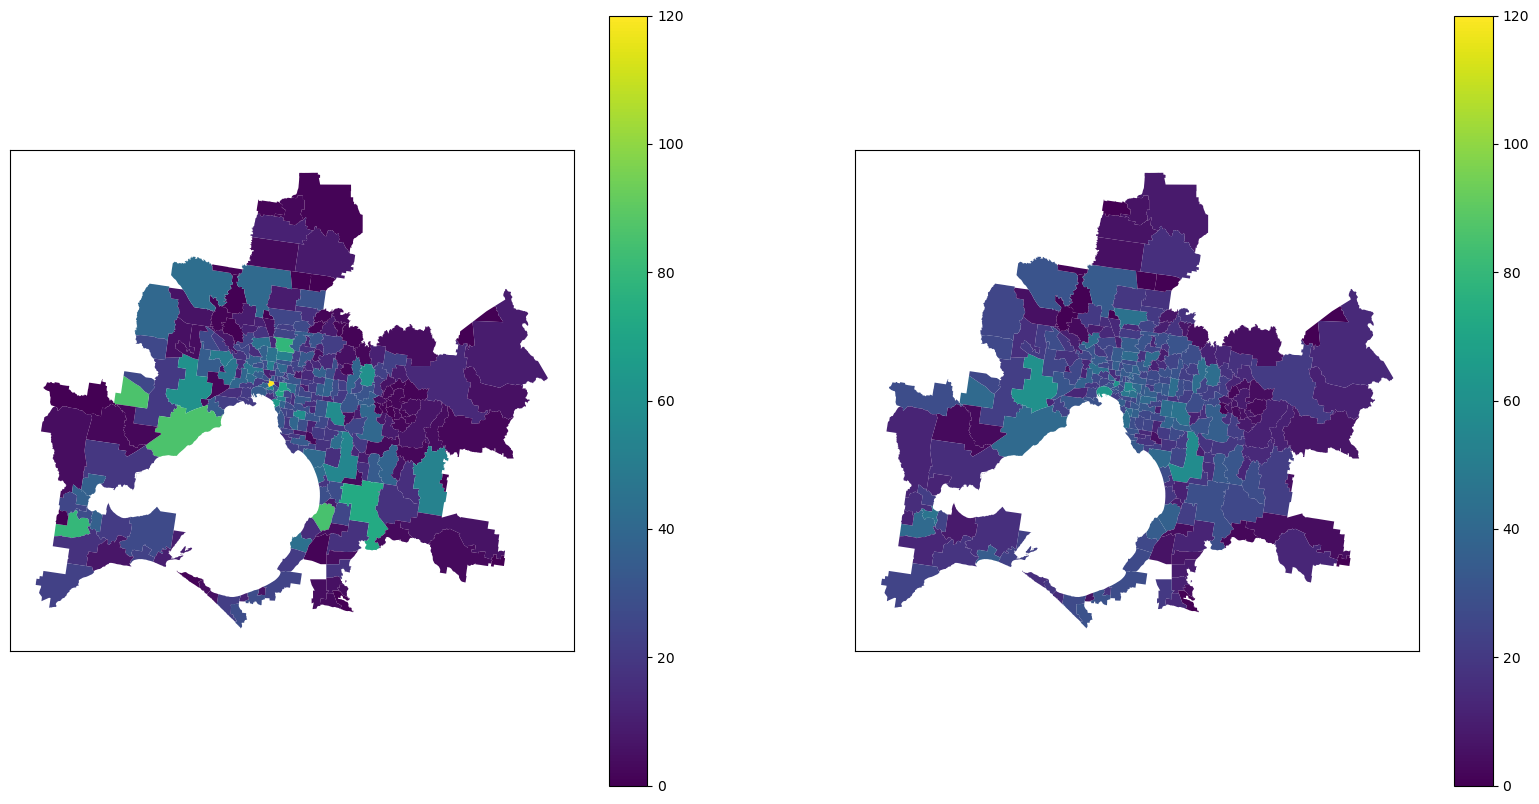

In [66]:
# Plotting 
max_value = max(pred_poa["pred"].max(), pred_poa["TOTAL1"].max())

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
pred_poa.plot(column="pred", ax=axes[0], legend=True, cmap='viridis',  vmax=max_value)
pred_poa.plot(column="TOTAL1", ax=axes[1], legend=True, cmap='viridis',  vmax=max_value)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])
plt.show()

In [57]:
pred_poa.mean()

C:\Users\danla\AppData\Local\Temp\ipykernel_12572\3876666263.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  pred_poa.mean()


POA_CODE21          inf
TOTAL1        20.310458
pred          19.722222
dtype: float64

In [215]:
categorical_columns = ["dwelltype_Flat or Apartment", "dwelltype_Separate House", "dwelltype_Terrace/Townhouse",
                       "owndwell_Being Purchased", "owndwell_Being Rented", "owndwell_Fully Owned", "owndwell_Occupied Rent-Free"]

hist_values = []
num_bins = 10 

sa1_list = synthetic_merged["SA1"].unique()#[:4000]
i = 0

for sa1_selected in sa1_list:
    hist_values_sa1 = []
    selected = synthetic_merged[synthetic_merged["SA1"] == sa1_selected]

    i = i + 1
    if i % 100 == 0:  
        print(i)

    for attribute in ["INC", "TOTALVEHS", "HHSIZE"]:
        hist, _ = np.histogram(selected[attribute], bins=num_bins)
        hist_values_sa1.extend(hist)
    
    categorical_sums = selected[categorical_columns].sum().values
    hist_values_sa1.extend(categorical_sums)

    hist_values.append(hist_values_sa1)

data = np.array(hist_values)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900


In [217]:
sa1_pred = cnn_model.predict(data).flatten()
data = {'SA1': sa1_list, 'sa1_pred': sa1_pred}
df = pd.DataFrame(data)
df

374/374 [==============================] - 0s 669us/step


In [219]:
unique_sa1_values  = synthetic_merged[["SA1", "geometry"]].drop_duplicates(subset="SA1")
mysa1_merge = unique_sa1_values.merge(df, on="SA1", how="left")
mysa1_merge.loc[pd.isna(mysa1_merge["sa1_pred"]), "sa1_pred"] = 0
mysa1_merge

In [246]:
pred_sa1_plot = sa1.merge(mysa1_merge[["SA1", "sa1_pred"]], left_on="SA1_CODE21", right_on="SA1", how='left')
pred_sa1_plot.loc[pd.isna(pred_sa1_plot["sa1_pred"]), "sa1_pred"] = 0
pred_sa1_plot

,SA1_CODE21,POA_CODE21,geometry,SA1,sa1_pred
0,20102100908,3340,"MULTIPOLYGON (((144.44381 -37.86401, 144.44362...",NaN,0.000000
1,20102100910,3340,"MULTIPOLYGON (((144.32480 -37.84446, 144.32497...",NaN,0.000000
2,20301103507,3331,"MULTIPOLYGON (((144.24563 -38.01367, 144.24580...",20301103507,0.367945
3,20301103607,3217,"MULTIPOLYGON (((144.29277 -38.26928, 144.29279...",20301103607,0.487588
4,20301103608,3240,"POLYGON ((144.24608 -38.21148, 144.24617 -38.2...",20301103608,0.292830
...,...,...,...,...,...
11946,21402159219,3931,"POLYGON ((145.02982 -38.22619, 145.02947 -38.2...",21402159219,0.175484
11947,21402159220,3931,"POLYGON ((145.03348 -38.23112, 145.03351 -38.2...",21402159220,0.773148
11948,21402159221,3931,"POLYGON ((145.04023 -38.22754, 145.03973 -38.2...",21402159221,0.276295
11949,21402159222,3931,"POLYGON ((145.02819 -38.23559, 145.02932 -38.2...",21402159222,0.308920


<Axes: >

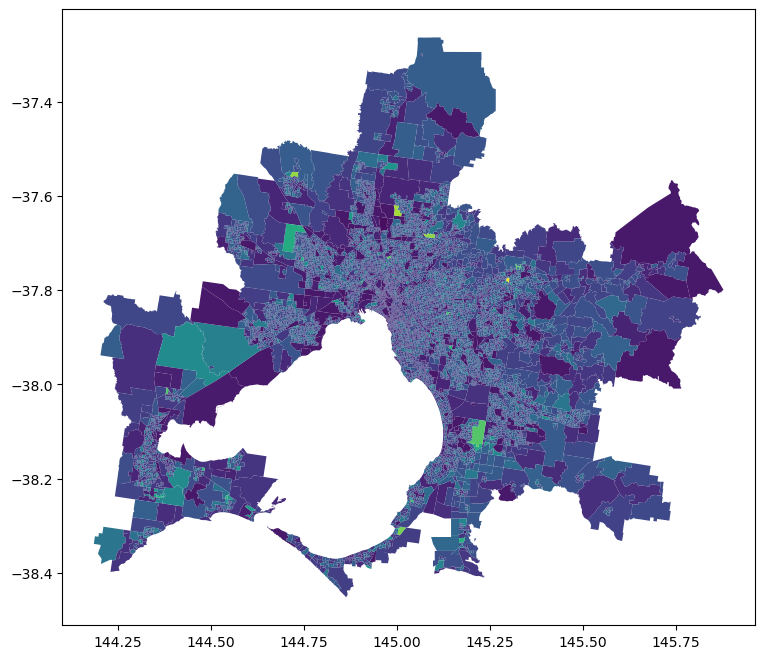

In [250]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the GeoDataFrame with the adjusted figure size
pred_sa1_plot.plot(column="sa1_pred", ax=ax)